In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import Learn_Koopman_with_Klinear_Franka as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import pybullet as pb
import pybullet_data
import math
import sys
sys.path.append("control/utility")
# Franka simulator
from franka_env import FrankaEnv
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility")
##MPC
import lqr
import mpc
import time
from cvxopt import solvers
from cvxopt import matrix

In [2]:
#load network
suffix = "DKUC_SOC_franka"
env_name = "Franka"
layer_depth = 3
encode_dim = 20
gamma = 0.8
all_loss =1 
eloss = 0
# env_name = "Pendulum-v1"
env = FrankaEnv(render = False)
in_dim = env.Nstates
u_dim = env.udim
subsuffix =suffix+"KK_"+env_name+"layer{}_edim{}_eloss{}_gamma{}_aloss{}".format(layer_depth,encode_dim,eloss,gamma,all_loss)
# print(subsuffix)
dicts = torch.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/franka_data/"+subsuffix+".pth",map_location=None)
#dicts = torch.load(subsuffix+".pth",map_location=None)
state_dict = dicts["model"]
Elayer = dicts["layer"]
# print(layers)
Nkoopman = encode_dim+in_dim
net = lka.Network(Elayer,Nkoopman,u_dim)
net.load_state_dict(state_dict)
device = torch.device("cpu")
net.cpu()
net.double()

Network(
  (encode_net): Sequential(
    (linear_0): Linear(in_features=17, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=20, bias=True)
  )
  (lA): Linear(in_features=37, out_features=37, bias=False)
  (lB): Linear(in_features=7, out_features=37, bias=False)
)

In [3]:
Samples = 20000 # Number of random initial conditions for both training and testing data
ts = 0.02 # time spacing between training state measurements
tFinal = 0.3 # time horizon --- used in measuring error

NKoopman = encode_dim + in_dim # Number of basis functions (keep inside [2,4])
Nstates = in_dim # Number of system states
Ncontrol = u_dim # Number of system inputs

timeSteps = round(tFinal/ts)+1

def Psi_k(s, u,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman+Ncontrol,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    psi[NKoopman:] = u
    return psi

def Psi_o(s,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    return psi

def A_and_G(s_1, s_2, u,net): # Uses measurements s(t_k) & s(t_{k+1}) to calculate A and G
    A = np.dot(Psi_k(s_2, u,net), Psi_k(s_1, u,net).T)
    G = np.dot(Psi_k(s_1, u,net), Psi_k(s_1, u,net).T)
    return A, G

def A_and_G_o(s_1, s_2, u,net): # Uses measurements s(t_k) & s(t_{k+1}) to calculate A and G
    A = np.dot(Psi_o(s_2, u,net), Psi_o(s_1, u,net).T)
    G = np.dot(Psi_o(s_1, u,net), Psi_o(s_1, u,net).T)
    return A, G

def Obs(o):
    noise = np.random.randn(3)*1e-1
    noise = np.random.randn(3)*0
    return np.concatenate((o[:3]+noise,o[7:]),axis=0),noise

In [4]:
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
eig = scipy.linalg.eigvals(Ad)
# print("Eigs of the matrix:{}".format(eig))
print("The max eigen of Kd is {}".format(max(eig)) )

The max eigen of Kd is (1.000006982665647+0j)


Text(0, 0.5, 'z (m)')

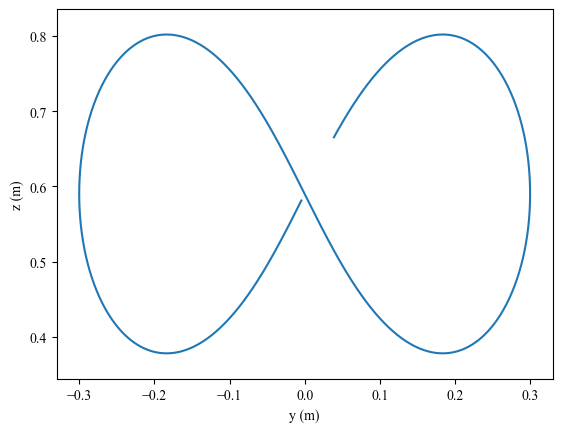

In [5]:
env.reset()
nStates = 10
accuracy_invKin = 0.000001
T = 6 *10 # time horizon 
t = 1.6 + 0.02*np.linspace(0, T*5, T*50+1) # time steps
Steps = len(t)-1

import matplotlib as mpl
mpl.rcParams['font.family'] = ['Times New Roman']
a = 0.3 # scaling parameter of Fig. 8 area
x = 0.3*np.ones((len(t),1)) 
z = np.expand_dims(0.59 + 2* a * np.sin(t) * np.cos(t) / (1+np.sin(t)**2), axis = 1)
y = np.expand_dims(a * np.cos(t) / (1+np.sin(t)**2), axis = 1)
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)')
plt.ylabel('z (m)')

In [6]:
def quat_to_euler(q):
    """ 
    Function that converts quaternions to Euler angles
    
    Inputs
    ------
    q : quaternions
    
    Outputs
    -------
    
    phi, theta, psi : Euler angles
    """
    pi = math.pi
    q0, q1, q2, q3 = q[3], q[0], q[1], q[2]
    test = np.dot(q0,q2) - np.dot(q1,q3)
    if (test > 0.4999): 
        phi = math.atan2(q1*q2 - q0*q3, q1*q3 + q0*q2)
        theta = pi/2
        psi= 0
    elif (test < -0.4999):
        phi = math.atan2(- q1*q2 + q0*q3, - q1*q3 - q0*q2)
        theta = -pi/2
        psi = 0
    else:
        sqx = q1*q1
        sqy = q2*q2
        sqz = q3*q3
        
        psi = math.atan2(2*q2*q1+2*q0*q3 , 1 - 2*sqy - 2*sqz) # Yaw
        theta = math.asin(2*test) # Pitch
        phi = math.atan2(2*q2*q3+2*q0*q1 , 1 - 2*sqx - 2*sqy) # Roll
    return phi, theta, psi

def Psi_x(x): 
    return x

def Run_Franka(Steps, state_desired, M_MPC,C_MPC,net, x0 = None, y0 = None, z0 = None):
    """
    Function that simulates forward the dynamics of Franka using LQR control, 
    given a desired trajectory and LQR gains
    
    Inputs
    ------
    Steps : Number of steps to propagate discrete dynamics into the future
    state_desired: desired trajectory to track (used for the applied control)
    LQR_gains: LQR gains used together with the current state and desired trajectory 
            to compute control response
            
    Outputs
    -------
    state_traj : state trajectory of the controlled system
    control_traj : control trajectory that was applied to the system
    """
    
    state = env.reset()
    
    # Set state to desired state to help initiation
    for i, jnt in enumerate(state_desired[0,3:9]):
            pb.resetJointState(env.robot, i, jnt)
    
    # set initial y,z states to given y0, z0
    if x0:
        JointAngles_Fig8 = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x0, y0, z0], accuracy_invKin, 10000)
        for i, jnt in enumerate(JointAngles_Fig8[0:6]):
            pb.resetJointState(env.robot, i, jnt)

    state = env.get_state()

    # Initialize states and controls trajectories
    state_traj, control_traj = np.empty((Steps+1,NKoopman)), np.empty((Steps, 7))
    state_traj[:], control_traj[:] = np.NaN,  np.NaN
    # Simulate dynamics forward
    control_real = np.zeros((1, Steps))
    for t in range(Steps):
        state,noise = Obs(state)
        state = Psi_o(state,net)
        state_traj[t, :] = state[:NKoopman].reshape(-1)
        state_traj[t, :3] -= noise
        
        deltax = state - Psi_o(state_desired[t+1,:],net)
        #print(deltax.shape)
        #print(C_MPC.shape)
        T_MPC = np.dot(C_MPC,deltax)
        T_MPC = matrix(T_MPC)
        test1 = mpc.Prediction(M_MPC,T_MPC)
        #print(T_MPC.size)
        #control_real[:,t-1] = mpc.Prediction(M_MPC,T_MPC,N = 7)
        #print(test1.shape) 
        #control = control_real[:,t-1]
        control = mpc.Prediction(M_MPC,T_MPC,N = 7)
        #control = np.zeros((7, 1))
        #print(control.shape)
        #control = - np.dot(LQR_gains, (state - Psi_o(state_desired[t+1,:],net)))
        control_traj[t, :] = control.reshape(-1)
        state = env.step(control)
#         time.sleep(1.0/6000.)
#         time.sleep(1.0/600000.)
    
    state,noise = Obs(state)
    state = Psi_o(state,net)
    state_traj[t+1, :] = state[:NKoopman].reshape(-1)
    state_traj[t+1, :3] -= noise
    return state_traj, control_traj

def accurateCalculateInverseKinematics(kukaId, endEffectorId, targetPos, threshold, maxIter):
    """
    Calculates the joint poses given the End Effector location using inverse kinematics
    Note: It changes the Franka configuration during the optimization to the desired configuration
    
    Input: 
    kukaId : Object that represents the Franka system
    endEffectorId : 
    targetPos : 
    threshold : accuracy threshold
    maxIter : maximum iterations to fine tune solution
    
    Output: 
    jointPoses: The angles of the 7 joints of the Franka 
    """
    numJoints = 7
    closeEnough = False
    iter = 0
    dist2 = 1e30
    while (not closeEnough and iter < maxIter):
        jointPoses = pb.calculateInverseKinematics(kukaId, endEffectorId, targetPos)
    
        for i in range(numJoints):
            pb.resetJointState(kukaId, i, jointPoses[i])
        ls = pb.getLinkState(kukaId, endEffectorId)
        newPos = ls[4]
        diff = [targetPos[0] - newPos[0], targetPos[1] - newPos[1], targetPos[2] - newPos[2]]
        dist2 = (diff[0] * diff[0] + diff[1] * diff[1] + diff[2] * diff[2])
        closeEnough = (dist2 < threshold)
        iter = iter + 1
    return jointPoses[:7]

def runLQRonFranka(steps, desired_target, M_MPC,C_MPC,net, x0 = None, y0 = None, z0 = None, method = False):
    """
    Executes a simulation of specified number of steps applying LQR on Franka with the input LQR gains
        
    Inputs
    ------
    steps : number of steps to forward simulate the system
    desired_target : desired_trajectory to track
    LQR_gains : LQR gains used to compute control
    method : method to print on pdf label; if none is specified, no pdf is created
"""
    state_traj, controls_traj = Run_Franka(steps, desired_target, M_MPC,C_MPC,net, x0, y0, z0)

    error = np.linalg.norm(state_traj[:,:nStates] - desired_target[:,:nStates])
    if method:
        fig = plt.plot(state_traj[:,1], state_traj[:,2], 'b-', linewidth = 1, markersize = 1)
        plt.plot(desired_target[:,1], desired_target[:,2], 'k--', linewidth = 1)
        plt.axis('equal')
        plt.title(method +': Error = {0:.2f}'.format(error), fontdict=None, loc='center', pad=None)
    return state_traj, controls_traj, error

def desiredStates_from_EndEffector(xyzEndEffector):
    """
    This function takes in the x,y,z coordinates of the end effector (EE) of Franka 
    and returns the closest (locally, using Inverse Kinematics) desired configuration
    to achieve that EE position . 
    
    Inputs
    ------
    x_d, y_d, z_d: End effector coordinates
    
    Outputs
    desired_states: x, y, z, JointAngles, Joint Velocities
    """
    x_d, y_d, z_d = xyzEndEffector[0], xyzEndEffector[1], xyzEndEffector[2]
    jointAngles = np.asarray(accurateCalculateInverseKinematics(env.robot, env.ee_id, [x_d, y_d, z_d], accuracy_invKin, 10000))
    state_des = np.concatenate((xyzEndEffector, jointAngles, np.zeros(7)))

    return state_des

In [7]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [8]:
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility")
##MPC
import lqr
import mpc
import time
from cvxopt import solvers
from cvxopt import matrix
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q = np.zeros((NKoopman,NKoopman))
Q[:10,:10] = np.eye(10)
R = 0.08*np.eye(7)
Q = np.matrix(Q)
R = np.matrix(R)
F = Q
N_MPC = 20
M_MPC,C_MPC = mpc.cal_matrices(Ad,Bd,Q,R,F,N_MPC)
M_MPC = matrix(M_MPC)

#print(Kopt.shape)

In [9]:
from scipy.io import loadmat, savemat
np.random.seed(0)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(1):
    #y0, z0 = y[0,0], z[0,0]
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    #y0, z0 = y[0,0] + np.random.uniform(-0.1, 0.1, 1), z[0,0] + np.random.uniform(-0.1, 0.1, 1)
    state_traj_KP, controls_traj_KP, error_KP = runLQRonFranka(Steps, states_des, M_MPC,C_MPC,net, x[0,0], y0, z0)
    savemat('Results/DKUC_FrankaFig8noise_SimData1'+str(i)+'.mat', {'desired_states':states_des,  'states_KoopmanU': state_traj_KP, 
                                                    'error_KoopmanU':error_KP,
                                                                        'y0':y0, 'z0':z0}) # save variables to Matlab file
    

[[1.24599185]]


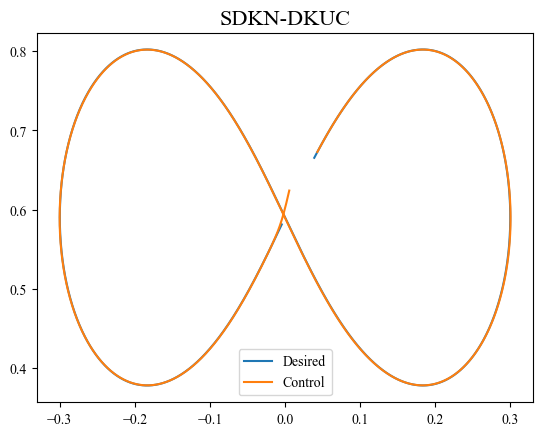

In [10]:
trajs = loadmat('Results/DKUC_FrankaFig8noise_SimData10.mat')
state_traj_LS = trajs['states_KoopmanU']
desired_traj = trajs['desired_states']
np.save('U1-1.npy', states_des)
np.save('U1-2.npy', state_traj_KP)
plt.plot(states_des[:,1],states_des[:,2],label='Desired')
plt.plot(state_traj_KP[:,1],state_traj_KP[:,2],label='Control')
print(trajs['error_KoopmanU'])
plt.legend()
plt.title("SDKN-DKUC",fontsize=16)
plt.savefig("D:/毕业设计/论文/pictures/franka/"+env_name+"_Ufrankawuqiong"+".png",dpi = 400)
plt.show()

Text(0, 0.5, 'z (m)')

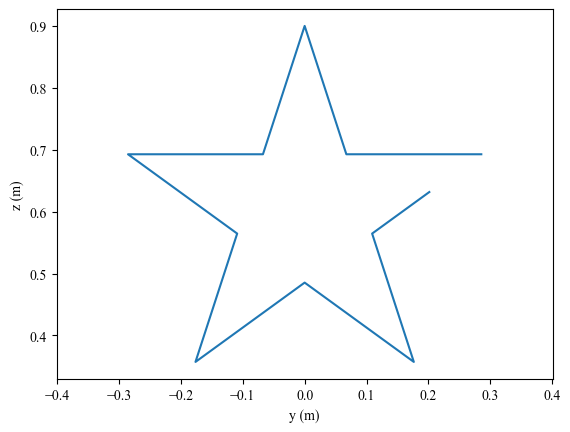

In [11]:
center = np.array([0.0,0.6])
radius = 0.3
theta_ = np.pi/10.0
eradius = np.tan(2*theta_)*radius*np.cos(theta_)-radius*np.sin(theta_) 
Star_points = np.zeros((11,2))
for i in range(5):
    theta = 2*np.pi/5*(i+0.25)
    Star_points[2*i,0] = np.cos(theta)*radius+center[0]
    Star_points[2*i,1] = np.sin(theta)*radius+center[1]
    beta = 2*np.pi/5*(i+0.75)
    Star_points[2*i+1,0] = np.cos(beta)*eradius+center[0]
    Star_points[2*i+1,1] = np.sin(beta)*eradius+center[1]    
Star_points[-1,:] = Star_points[0,:]
T = 6 *10 # time horizon 
t = 0.02*np.linspace(0, T*5, T*50+1) # time steps
refs = np.zeros((len(t),2))
Steps = len(t)-1
each_num = int((len(t)-10)/9.5)
for i in range(10):
    refs[(each_num+1)*i,:] = Star_points[i,:]
    if i!= 9:
        num = each_num
    else:
        num = len(t)-(each_num+1)*i-1
    for j in range(num):
        t_ = (j+1)/(each_num+1)
        refs[(each_num+1)*i+j+1,:] =  t_*Star_points[i+1,:] + (1-t_)*Star_points[i,:]
# print(each_num,each_num*10.5)
# print(t.shape)
# plt.plot(Star_points[:,0],Star_points[:,1])
x = 0.3*np.ones((len(t),1)) 
z = refs[:,1].reshape(-1,1)
y =  refs[:,0].reshape(-1,1)
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)')
plt.ylabel('z (m)')

In [12]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [13]:
np.random.seed(0)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(1):
    #y0, z0 = y[0,0], z[0,0]
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    #y0, z0 = y[0,0] + np.random.uniform(-0.1, 0.1, 1), z[0,0] + np.random.uniform(-0.1, 0.1, 1)
    state_traj_KP, controls_traj_KP, error_KP = runLQRonFranka(Steps, states_des,M_MPC,C_MPC,net, x[0,0], y0, z0)
    savemat('Results/DKUC_FrankaFigStarnoise_SimData1'+str(i)+'.mat', {'desired_states':states_des,  'states_KoopmanU': state_traj_KP, 
                                                    'error_KoopmanU':error_KP,
                                                                        'y0':y0, 'z0':z0}) # save variables to Matlab file
    

[[1.4139089]]


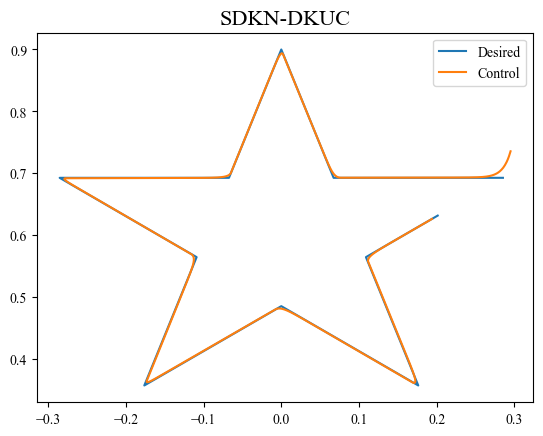

In [14]:
trajs = loadmat('Results/DKUC_FrankaFigStarnoise_SimData10.mat')
state_traj_LS = trajs['states_KoopmanU']
desired_traj = trajs['desired_states']
np.save('U2-1.npy', states_des)
np.save('U2-2.npy', state_traj_KP)
plt.plot(states_des[:,1],states_des[:,2],label='Desired')
plt.plot(state_traj_KP[:,1],state_traj_KP[:,2],label='Control')
print(trajs['error_KoopmanU'])
plt.legend()
plt.title("SDKN-DKUC",fontsize=16)
plt.savefig("D:/毕业设计/论文/pictures/franka/"+env_name+"_Ufrankastar"+".png",dpi = 400)
plt.show()

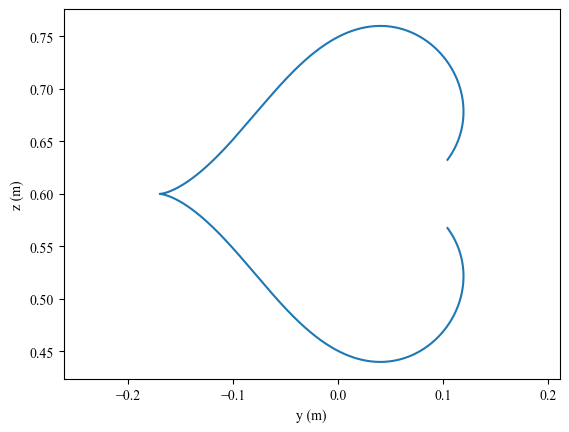

In [15]:
T = 6 *10 # time horizon 
t = 1.6 + 0.02*np.linspace(0, T*5, T*50+1) # time steps
Steps = len(t)-1
a = 0.3 # scaling parameter of Fig. 8 area
theta = np.linspace(0.2*np.pi, 1.8*np.pi, len(t))
#r = np.sin(4*theta) + 0.5*np.sin(4*theta)
x = 0.3*np.ones((len(t),1)) 
z = np.expand_dims(16 * 0.01*np.sin(theta)**3+0.6, axis = 1)
y = np.expand_dims(13 * 0.01*np.cos(theta) - 5 * 0.01*np.cos(2*theta) - 2 *0.01* np.cos(3*theta) - 0.01*np.cos(4*theta), axis = 1)
plt.xlim([-0.3,0.3])
plt.plot(y,z)
plt.axis('equal')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.savefig("D:/毕业设计/论文/pictures/franka/"+env_name+"_Ufrankaheart_target"+".png",dpi = 500)

In [16]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [17]:
np.random.seed(0)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(1):
    y0, z0 = y[0,0] , z[0,0]
    #y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    #y0, z0 = y[0,0] + np.random.uniform(-0.1, 0.1, 1), z[0,0] + np.random.uniform(-0.1, 0.1, 1)
    state_traj_KP, controls_traj_KP, error_KP = runLQRonFranka(Steps, states_des,M_MPC,C_MPC,net, x[0,0], y0, z0)
    savemat('Results/DKUC_FrankaFigheartnoise_SimData1'+str(i)+'.mat', {'desired_states':states_des,  'states_KoopmanU': state_traj_KP, 
                                                    'error_KoopmanU':error_KP,
                                                                        'y0':y0, 'z0':z0}) # save variables to Matlab file
    

[[0.50306692]]


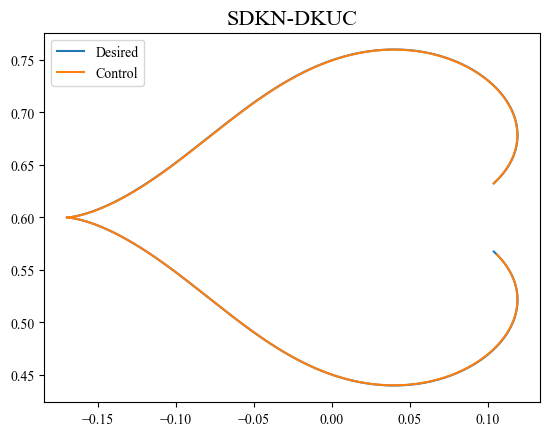

In [18]:
trajs = loadmat('Results/DKUC_FrankaFigheartnoise_SimData10.mat')
state_traj_LS = trajs['states_KoopmanU']
desired_traj = trajs['desired_states']
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Times New Roman']
plt.plot(states_des[:,1],states_des[:,2],label='Desired')
plt.plot(state_traj_KP[:,1],state_traj_KP[:,2],label='Control')
print(trajs['error_KoopmanU'])
plt.legend()
plt.title("SDKN-DKUC",fontsize=16)
plt.savefig("D:/毕业设计/论文/pictures/franka/"+env_name+"_Ufrankaheart"+".png",dpi = 500)
plt.show()

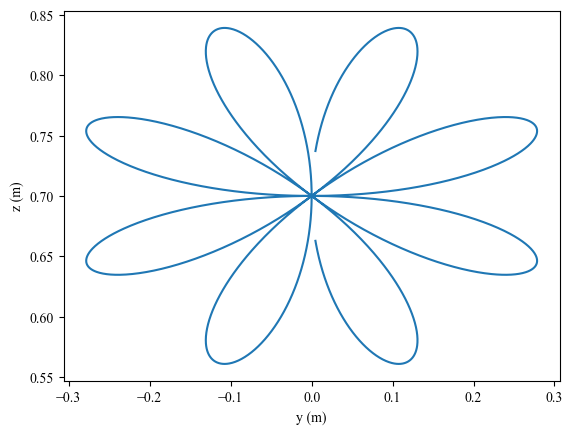

In [19]:
T = 6 *10 # time horizon 
t = 1.6 + 0.02*np.linspace(0, T*5, T*50+1) # time steps
Steps = len(t)-1
a = 0.3 # scaling parameter of Fig. 8 area
theta = np.linspace(0.02*np.pi, 1.98*np.pi, len(t))
r = np.sin(4*theta) + 0.5*np.sin(4*theta)
x = 0.3*np.ones((len(t),1)) 
z = np.expand_dims(0.1*r * np.cos(theta)+0.7, axis = 1)
y = np.expand_dims(0.2*r * np.sin(theta), axis = 1)
plt.plot(y,z)
#plt.axis('equal')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.savefig("D:/毕业设计/论文/pictures/franka/"+env_name+"_Ufrankaflower_target"+".png",dpi = 500)

In [20]:
# Translate desired y-z coordinates to desired joint angles of the Franka robotic arm
JointAngles_Fig8 = np.empty((len(t),7))
JointAngles_Fig8[:] = np.NaN
for i in range(len(t)):
    JointAngles_Fig8[i,:] = accurateCalculateInverseKinematics(env.robot, env.ee_id, [x[i], y[i], z[i]], accuracy_invKin, 10000)
states_des = np.concatenate( (x, y, z, JointAngles_Fig8, np.zeros((len(y), 7))), axis = 1)
# states_des = np.concatenate((x,y,z), axis = 1)


In [21]:
np.random.seed(0)
a = [0.01,0.021,-0.015,-0.012,0.093,0.058,0.014,-0.086,-0.096,0.056]
b = [0.043,0.009,0.029,0.078,-0.023,0.006,0.085,-0.083,0.067,0.074]
for i in range(1):
    #y0, z0 = y[0,0] , z[0,0]
    y0, z0 = y[0,0] + a[i], z[0,0] + b[i]
    #y0, z0 = y[0,0] + np.random.uniform(-0.1, 0.1, 1), z[0,0] + np.random.uniform(-0.1, 0.1, 1)
    state_traj_KP, controls_traj_KP, error_KP = runLQRonFranka(Steps, states_des,M_MPC,C_MPC,net, x[0,0], y0, z0)
    savemat('Results/DKUC_FrankaFigflowernoise_SimData1'+str(i)+'.mat', {'desired_states':states_des,  'states_KoopmanU': state_traj_KP, 
                                                    'error_KoopmanU':error_KP,
                                                                        'y0':y0, 'z0':z0}) # save variables to Matlab file
    

[[2.45119783]]


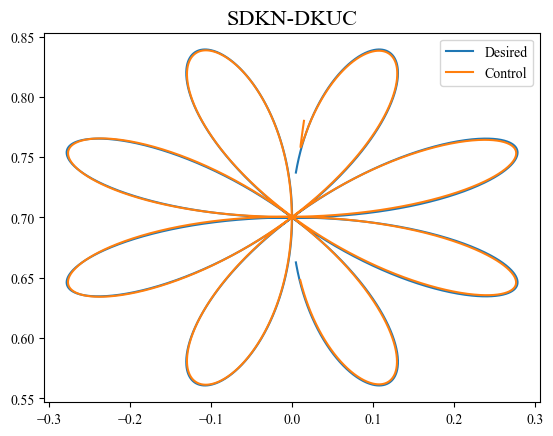

In [22]:
trajs = loadmat('Results/DKUC_FrankaFigflowernoise_SimData10.mat')
state_traj_LS = trajs['states_KoopmanU']
desired_traj = trajs['desired_states']
np.save('U3-1.npy', states_des)
np.save('U3-2.npy', state_traj_KP)
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Times New Roman']
plt.plot(states_des[:,1],states_des[:,2],label='Desired')
plt.plot(state_traj_KP[:,1],state_traj_KP[:,2],label='Control')
print(trajs['error_KoopmanU'])
plt.legend()
plt.title("SDKN-DKUC",fontsize=16)
plt.savefig("D:/毕业设计/论文/pictures/franka/"+env_name+"_Ufrankaflower"+".png",dpi = 500)
plt.show()